Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts.clean import clean_dataset
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 2.03 s
Wall time: 2.05 s


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.74      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.84      0.85      0.84     13567



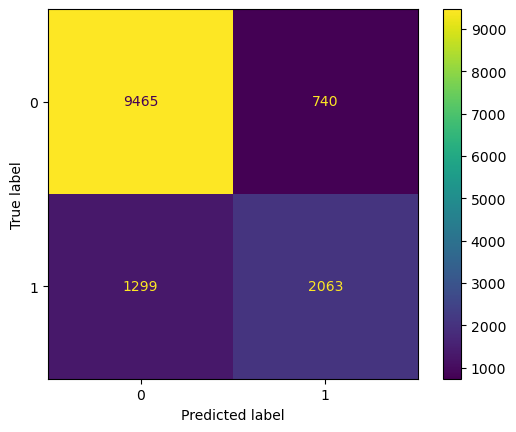

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.03,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.48it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████████████████████████████████████████████████████████████████████| 7263/7263 [00:00<00:00, 761733.10it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|███████████████████████████████████████████████████████████████████████████| 3523/3523 [00:00<00:00, 13266.15it/s]

Computing correctenesses for all valid if-thens.



100%|████████████████████████████████████████████████████████████████████████████| 10250/10250 [03:27<00:00, 49.44it/s]

Number of if-thens: 10250


In [ ]:
from gfacts.utils import load_rules_by_if, save_rules_by_if

### Use this for loading rules from disk
# rules_by_if = load_rules_by_if("rulesAdultFairTest_preproc.data")

### Use this for saving rules on disk
# save_rules_by_if("rulesAdultFairTest_preproc.data", rules_by_if)

In [10]:
# run this section if you load data from disk 

from gfacts.predicate import drop_two_above
ifthens = gfacts.rulesbyif2rules(rules_by_if)
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if gfacts.recIsValid(ifs,then,X_test,True)]
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
rules_by_if = gfacts.rules2rulesbyif(ifthens)

In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If capital-gain = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.76% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.27%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.27%.
	Protected Subgroup ' Male', 3.22% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 34.26%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 34.26%.
If capital-gain = 0, education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.62% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.40%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.40%.
	Protected Subgroup ' Male', 3.15% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 34.12%.
		Make education-num = 10, occupation =  Exec-managerial with correct

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [12]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

If capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Female', 85.80% covered out of 4064
		Make capital-gain = 15024 with correctness 68.83%.
		Make capital-gain = 7688 with correctness 24.63%.
		Make capital-gain = 7298 with correctness 22.91%.
		Make capital-gain = 15024 with correctness 68.83%.
		Make capital-gain = 7688 with correctness 24.63%.
		Make capital-gain = 7298 with correctness 22.91%.
		Aggregate cost of the above recourses = -3.64
	Protected Subgroup ' Male', 84.82% covered out of 6700
		Make capital-gain = 15024 with correctness 80.47%.
		Make capital-gain = 7688 with correctness 53.11%.
		Make capital-gain = 7298 with correctness 51.19%.
		Make capital-gain = 15024 with correctness 80.47%.
		Make capital-gain = 7688 with correctness 53.11%.
		Make capital-gain = 7298 with correctness 51.19%.
		Aggregate cost of the above recourses = -6.43
	Bias against  Female. Unfairness measure = 2.78.
	Cumulative correctness plot for the abo

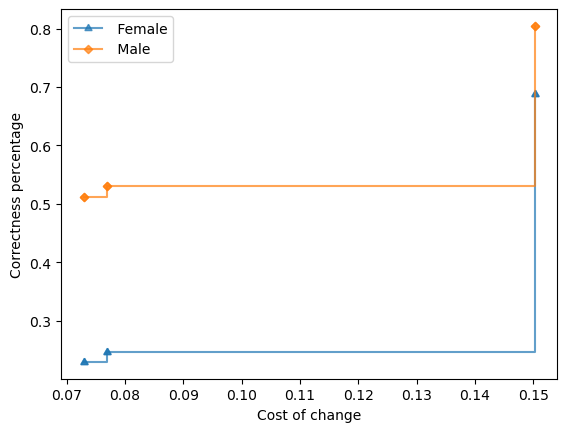

If capital-gain = 0, education-num = 10, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 3.62% covered out of 4064
		Make occupation =  Exec-managerial with correctness 2.04%.
		Make occupation =  Exec-managerial with correctness 2.04%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.00% covered out of 6700
		Make occupation =  Exec-managerial with correctness 20.40%.
		Make occupation =  Exec-managerial with correctness 20.40%.
		Aggregate cost of the above recourses = -0.20
	Bias against  Female. Unfairness measure = 0.18.
	Cumulative correctness plot for the above recourses:


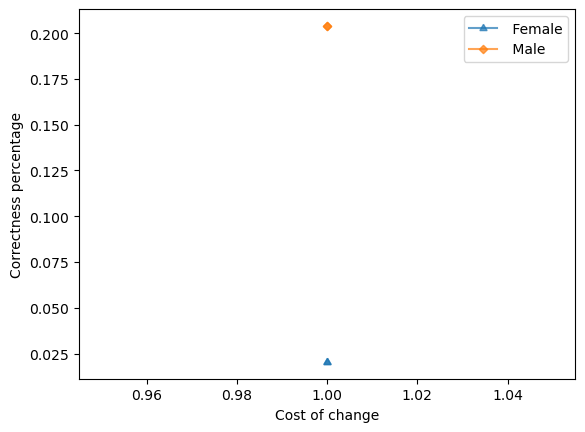

If capital-loss = 0, education-num = 10, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 3.62% covered out of 4064
		Make occupation =  Exec-managerial with correctness 2.04%.
		Make occupation =  Exec-managerial with correctness 2.04%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.03% covered out of 6700
		Make occupation =  Exec-managerial with correctness 20.20%.
		Make occupation =  Exec-managerial with correctness 20.20%.
		Aggregate cost of the above recourses = -0.20
	Bias against  Female. Unfairness measure = 0.18.
	Cumulative correctness plot for the above recourses:


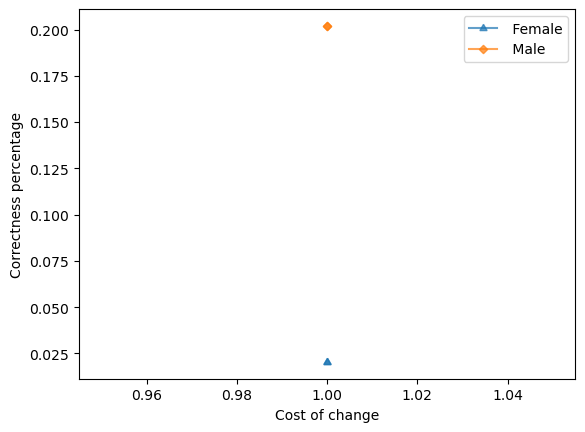

If Workclass =  Private, age = (26.0, 34.0], education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 3.03% covered out of 4064
		Make age = (41.0, 50.0] with correctness 2.44%.
		Make age = (41.0, 50.0] with correctness 2.44%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.40% covered out of 6700
		Make age = (41.0, 50.0] with correctness 20.18%.
		Make age = (41.0, 50.0] with correctness 20.18%.
		Aggregate cost of the above recourses = -0.20
	Bias against  Female. Unfairness measure = 0.18.
	Cumulative correctness plot for the above recourses:


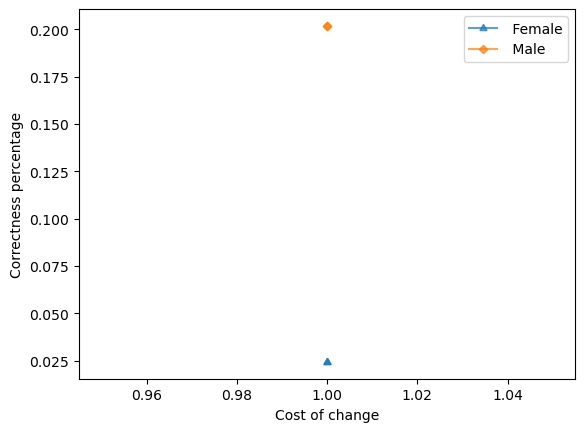

If capital-gain = 0, capital-loss = 0, education-num = 10, occupation =  Sales:
	Protected Subgroup ' Female', 3.67% covered out of 4064
		Make occupation =  Exec-managerial with correctness 2.01%.
		Make occupation =  Exec-managerial with correctness 2.01%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.10% covered out of 6700
		Make occupation =  Exec-managerial with correctness 19.71%.
		Make occupation =  Exec-managerial with correctness 19.71%.
		Aggregate cost of the above recourses = -0.20
	Bias against  Female. Unfairness measure = 0.18.
	Cumulative correctness plot for the above recourses:


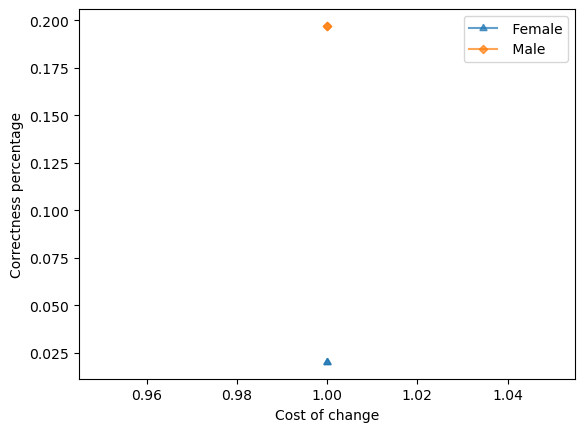

If education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.89% covered out of 4064
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.80%.
		Make occupation =  Exec-managerial with correctness 1.90%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 3.80%.
		Make occupation =  Exec-managerial with correctness 1.90%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.34% covered out of 6700
		Make education-num = 10, occupation =  Exec-managerial with correctness 33.48%.
		Make occupation =  Exec-managerial with correctness 17.86%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 33.48%.
		Make occupation =  Exec-managerial with correctness 17.86%.
		Aggregate cost of the above recourses = -0.16
	Bias against  Female. Unfairness measure = 0.14.
	Cumulative correctness plot for the above recourses:


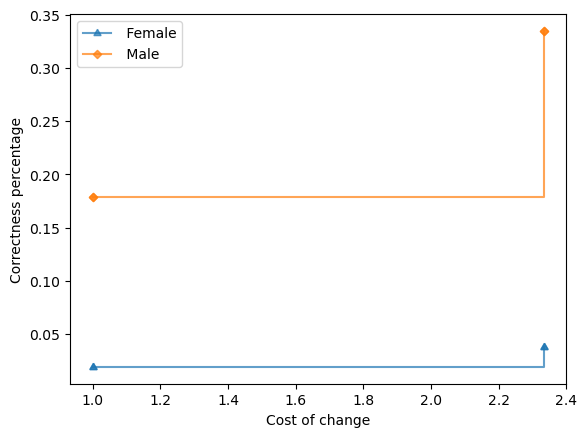

If Workclass =  Private, capital-gain = 0, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Female', 4.16% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 3.55%.
		Make occupation =  Prof-specialty with correctness 0.59%.
		Make occupation =  Exec-managerial with correctness 0.59%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.37%.
		Make hours-per-week = OverTime with correctness 0.59%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 3.55%.
		Make occupation =  Prof-specialty with correctness 0.59%.
		Make occupation =  Exec-managerial with correctness 0.59%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.37%.
		Make hours-per-week = OverTime with correctness 0.59%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 3.04% covered out of 6700
		Make hours-per-week = OverTime, occupatio

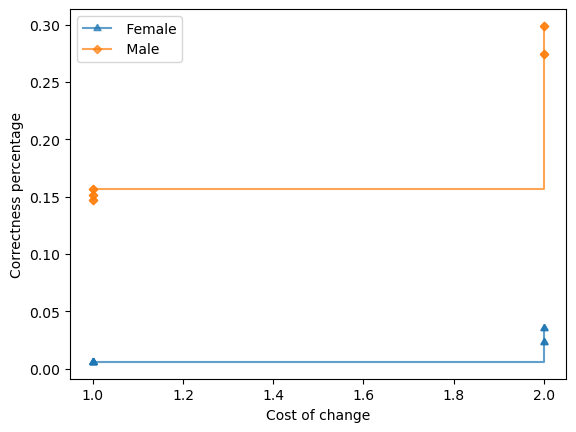

If Workclass =  Private, capital-loss = 0, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Female', 3.94% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 3.75%.
		Make occupation =  Prof-specialty with correctness 0.62%.
		Make occupation =  Exec-managerial with correctness 0.62%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.50%.
		Make hours-per-week = OverTime with correctness 0.62%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 3.75%.
		Make occupation =  Prof-specialty with correctness 0.62%.
		Make occupation =  Exec-managerial with correctness 0.62%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.50%.
		Make hours-per-week = OverTime with correctness 0.62%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 3.06% covered out of 6700
		Make hours-per-week = OverTime, occupatio

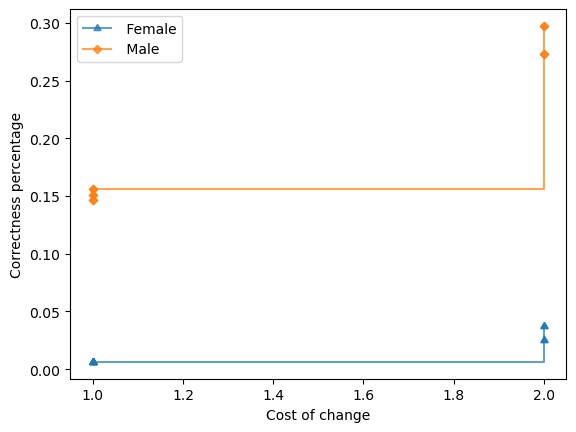

If capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 10.38% covered out of 4064
		Make occupation =  Exec-managerial with correctness 1.66%.
		Make occupation =  Prof-specialty with correctness 1.42%.
		Make occupation =  Exec-managerial with correctness 1.66%.
		Make occupation =  Prof-specialty with correctness 1.42%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 8.61% covered out of 6700
		Make occupation =  Exec-managerial with correctness 16.64%.
		Make occupation =  Prof-specialty with correctness 13.86%.
		Make occupation =  Exec-managerial with correctness 16.64%.
		Make occupation =  Prof-specialty with correctness 13.86%.
		Aggregate cost of the above recourses = -0.15
	Bias against  Female. Unfairness measure = 0.14.
	Cumulative correctness plot for the above recourses:


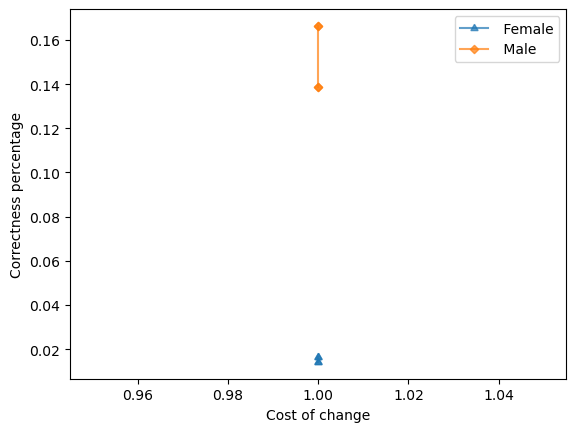

If age = (50.0, 90.0], hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Female', 5.93% covered out of 4064
		Make hours-per-week = OverTime with correctness 1.66%.
		Make hours-per-week = BrainDrain with correctness 2.49%.
		Make hours-per-week = OverTime with correctness 1.66%.
		Make hours-per-week = BrainDrain with correctness 2.49%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 7.63% covered out of 6700
		Make hours-per-week = OverTime with correctness 14.68%.
		Make hours-per-week = BrainDrain with correctness 16.83%.
		Make hours-per-week = OverTime with correctness 14.68%.
		Make hours-per-week = BrainDrain with correctness 16.83%.
		Aggregate cost of the above recourses = -0.16
	Bias against  Female. Unfairness measure = 0.14.
	Cumulative correctness plot for the above recourses:


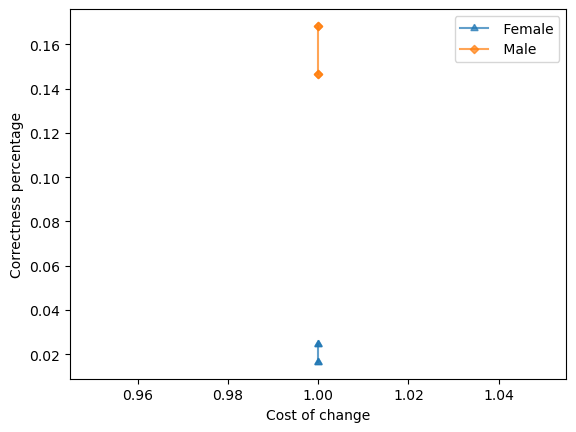

If capital-gain = 0, hours-per-week = FullTime, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.74% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 5.26%.
		Make occupation =  Prof-specialty with correctness 1.32%.
		Make occupation =  Exec-managerial with correctness 1.32%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 3.95%.
		Make hours-per-week = OverTime with correctness 1.32%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 7.89%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 5.26%.
		Make occupation =  Prof-specialty with correctness 1.32%.
		Make occupation =  Exec-managerial with correctness 1.32%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 3.95%.
		Make hours-per-week = OverTime with correctness 1.32%.
		Make hours-per-week = BrainDrain, occupation =  Exec-manageri

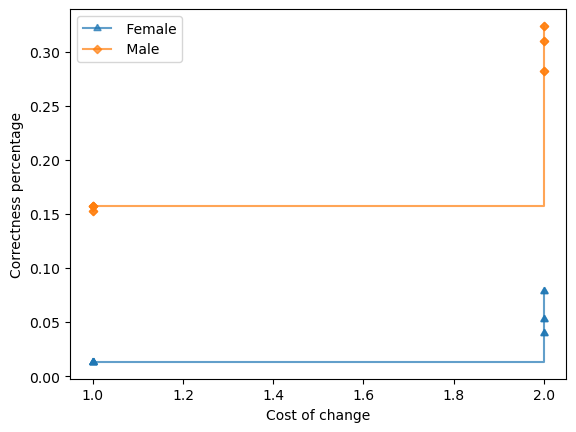

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 13.02% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 8.51%.
		Make occupation =  Prof-specialty with correctness 2.46%.
		Make occupation =  Exec-managerial with correctness 2.84%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 5.86%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 2.65%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 8.88%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 8.51%.
		Make occupation =  Prof-specialty with correctness 2.46%.
		Make occupation =  Exec-managerial with correctness 2.84%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 5.86%.
		Make hours-per-week = OverTime, occupation =  Sales w

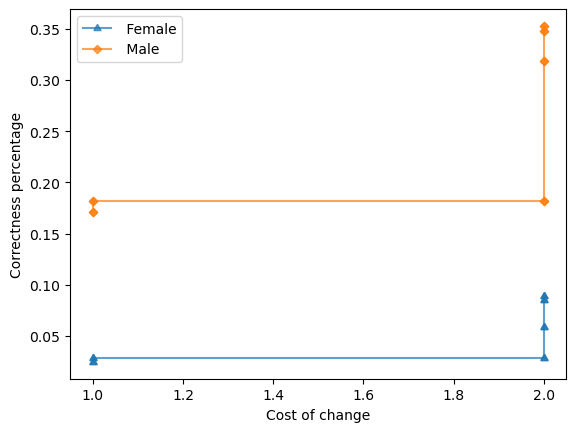

If capital-gain = 0, race =  Black:
	Protected Subgroup ' Female', 14.00% covered out of 4064
		Make race =  White with correctness 0.53%.
		Make capital-gain = 15024, race =  White with correctness 66.78%.
		Make capital-gain = 7688, race =  White with correctness 20.21%.
		Make capital-gain = 7298, race =  White with correctness 17.22%.
		Make race =  White with correctness 0.53%.
		Make capital-gain = 15024, race =  White with correctness 66.78%.
		Make capital-gain = 7688, race =  White with correctness 20.21%.
		Make capital-gain = 7298, race =  White with correctness 17.22%.
		Aggregate cost of the above recourses = -0.23
	Protected Subgroup ' Male', 8.43% covered out of 6700
		Make race =  White with correctness 3.19%.
		Make capital-gain = 15024, race =  White with correctness 77.52%.
		Make capital-gain = 7688, race =  White with correctness 40.18%.
		Make capital-gain = 7298, race =  White with correctness 38.05%.
		Make race =  White with correctness 3.19%.
		Make capital-ga

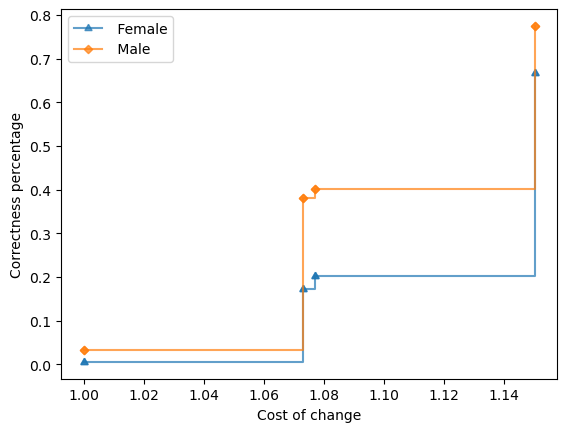

If Workclass =  Private, capital-gain = 0, education-num = 13, hours-per-week = FullTime:
	Protected Subgroup ' Female', 4.92% covered out of 4064
		Make hours-per-week = OverTime with correctness 1.50%.
		Make hours-per-week = OverTime with correctness 1.50%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.00% covered out of 6700
		Make hours-per-week = OverTime with correctness 13.93%.
		Make hours-per-week = OverTime with correctness 13.93%.
		Aggregate cost of the above recourses = -0.14
	Bias against  Female. Unfairness measure = 0.12.
	Cumulative correctness plot for the above recourses:


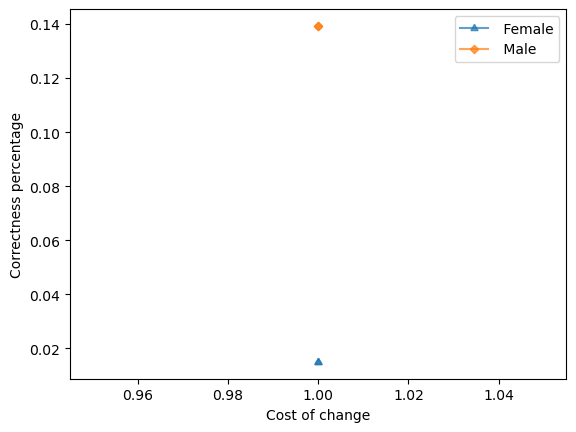

If capital-gain = 0, capital-loss = 0, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 19.73% covered out of 4064
		Make occupation =  Exec-managerial with correctness 2.49%.
		Make occupation =  Prof-specialty with correctness 1.87%.
		Make occupation =  Sales with correctness 0.37%.
		Make occupation =  Exec-managerial with correctness 2.49%.
		Make occupation =  Prof-specialty with correctness 1.87%.
		Make occupation =  Sales with correctness 0.37%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 4.88% covered out of 6700
		Make occupation =  Exec-managerial with correctness 17.74%.
		Make occupation =  Prof-specialty with correctness 15.90%.
		Make occupation =  Sales with correctness 6.42%.
		Make occupation =  Exec-managerial with correctness 17.74%.
		Make occupation =  Prof-specialty with correctness 15.90%.
		Make occupation =  Sales with correctness 6.42%.
		Aggregate cost of the above recourses = -0.13
	Bias against  Fe

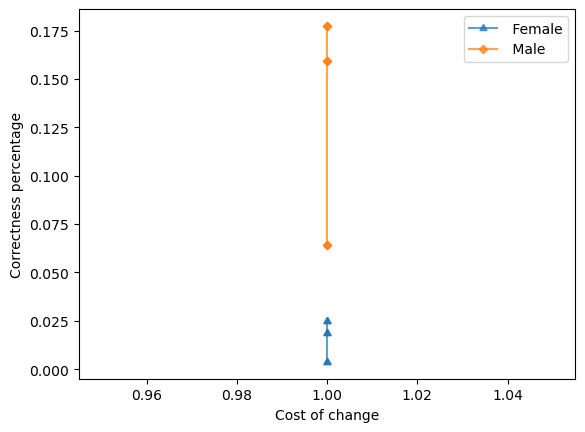

If Workclass =  Private, capital-gain = 0, native-country =  United-States, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 15.92% covered out of 4064
		Make occupation =  Exec-managerial with correctness 1.85%.
		Make occupation =  Prof-specialty with correctness 1.70%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 5.72%.
		Make occupation =  Exec-managerial with correctness 1.85%.
		Make occupation =  Prof-specialty with correctness 1.70%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 5.72%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.64% covered out of 6700
		Make occupation =  Exec-managerial with correctness 15.98%.
		Make occupation =  Prof-specialty with correctness 14.34%.
		Make occupation =  Sales with correctness 5.33%.
		Make Workclass =  Self-e

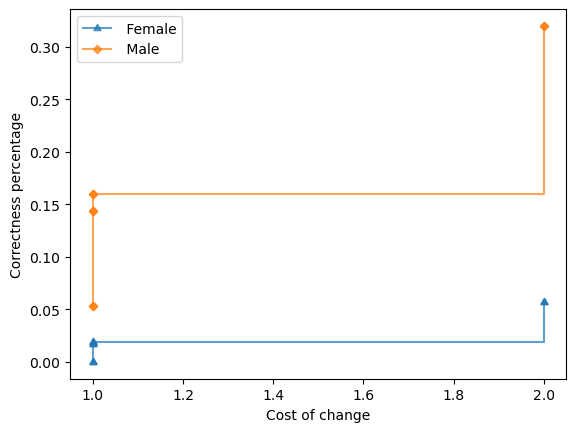

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, race =  White:
	Protected Subgroup ' Female', 9.89% covered out of 4064
		Make Workclass =  Self-emp-inc with correctness 1.24%.
		Make Workclass =  Self-emp-inc with correctness 1.24%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 9.61% covered out of 6700
		Make Workclass =  Self-emp-inc with correctness 12.27%.
		Make Workclass =  Self-emp-inc with correctness 12.27%.
		Aggregate cost of the above recourses = -0.12
	Bias against  Female. Unfairness measure = 0.11.
	Cumulative correctness plot for the above recourses:


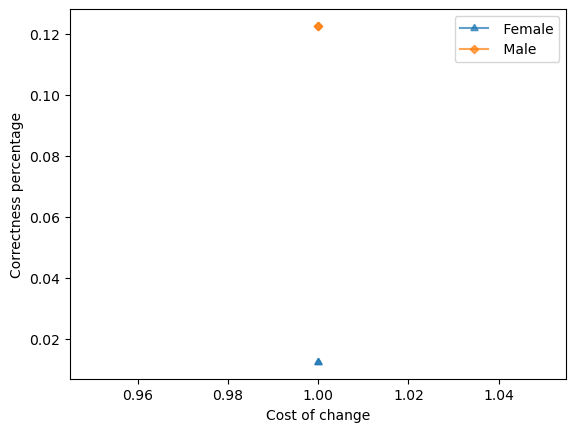

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Female', 10.95% covered out of 4064
		Make Workclass =  Self-emp-inc with correctness 0.90%.
		Make Workclass =  Self-emp-inc with correctness 0.90%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 9.73% covered out of 6700
		Make Workclass =  Self-emp-inc with correctness 11.35%.
		Make Workclass =  Self-emp-inc with correctness 11.35%.
		Aggregate cost of the above recourses = -0.11
	Bias against  Female. Unfairness measure = 0.1.
	Cumulative correctness plot for the above recourses:


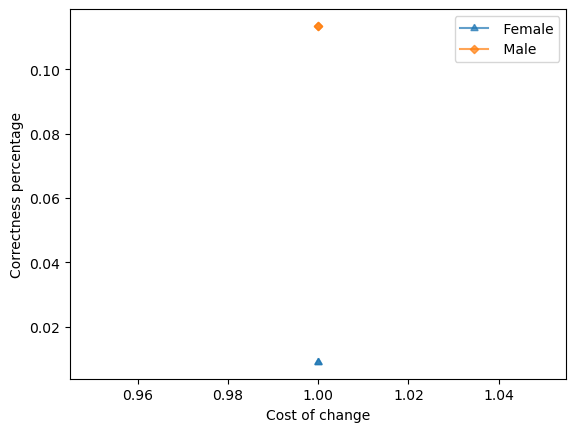

If age = (34.0, 41.0], capital-gain = 0, education-num = 10, native-country =  United-States:
	Protected Subgroup ' Female', 3.12% covered out of 4064
		Make age = (41.0, 50.0] with correctness 3.94%.
		Make age = (41.0, 50.0] with correctness 3.94%.
		Aggregate cost of the above recourses = -0.04
	Protected Subgroup ' Male', 4.13% covered out of 6700
		Make age = (41.0, 50.0] with correctness 14.08%.
		Make age = (41.0, 50.0] with correctness 14.08%.
		Aggregate cost of the above recourses = -0.14
	Bias against  Female. Unfairness measure = 0.1.
	Cumulative correctness plot for the above recourses:


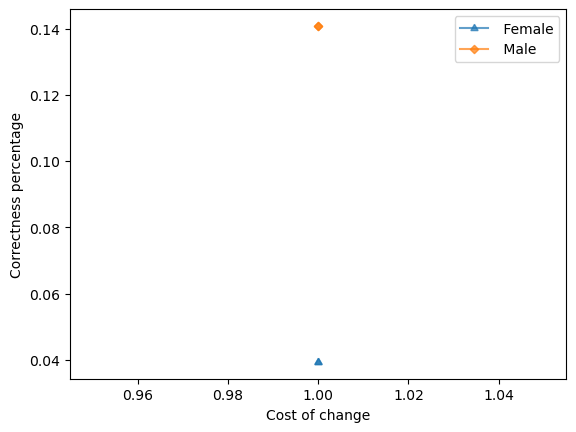

If capital-loss = 0, hours-per-week = FullTime, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 3.62% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 1.36%.
		Make occupation =  Prof-specialty with correctness 0.68%.
		Make occupation =  Exec-managerial with correctness 0.68%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 1.36%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 0.68%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 2.72%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 1.36%.
		Make occupation =  Sales with correctness 0.68%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 1.36%.
		Make occupation =  Prof-specialty with correctness 0.68%.
		Make occupation =  Exec-managerial with correctness 0.68%.
		Make hours-per-week = OverTime, occupation =  P

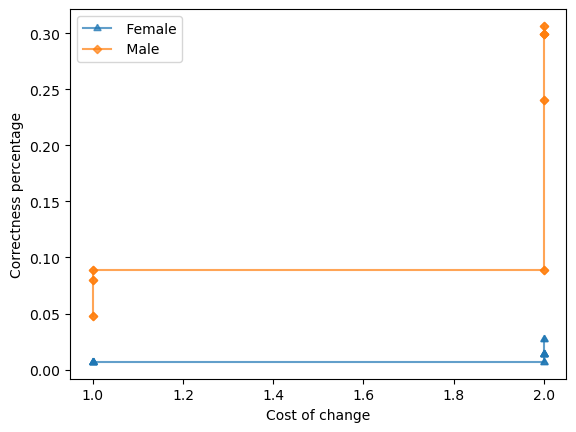

If Workclass =  Private, hours-per-week = FullTime, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 3.62% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 2.04%.
		Make occupation =  Prof-specialty with correctness 1.36%.
		Make occupation =  Exec-managerial with correctness 1.36%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.04%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 1.36%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 3.40%.
		Make occupation =  Sales with correctness 1.36%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 2.04%.
		Make occupation =  Prof-specialty with correctness 1.36%.
		Make occupation =  Exec-managerial with correctness 1.36%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.04%.
		Make hours-per-week = OverTime, occupation = 

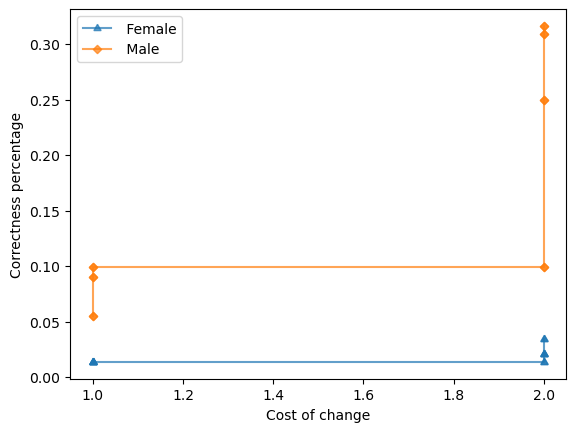

If capital-loss = 0, education-num = 11, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 3.49% covered out of 4064
		Make education-num = 13 with correctness 6.34%.
		Make education-num = 12 with correctness 0.70%.
		Make education-num = 13 with correctness 6.34%.
		Make education-num = 12 with correctness 0.70%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 3.13% covered out of 6700
		Make education-num = 13 with correctness 29.52%.
		Make education-num = 12 with correctness 13.33%.
		Make education-num = 13 with correctness 29.52%.
		Make education-num = 12 with correctness 13.33%.
		Aggregate cost of the above recourses = -0.11
	Bias against  Female. Unfairness measure = 0.09.
	Cumulative correctness plot for the above recourses:


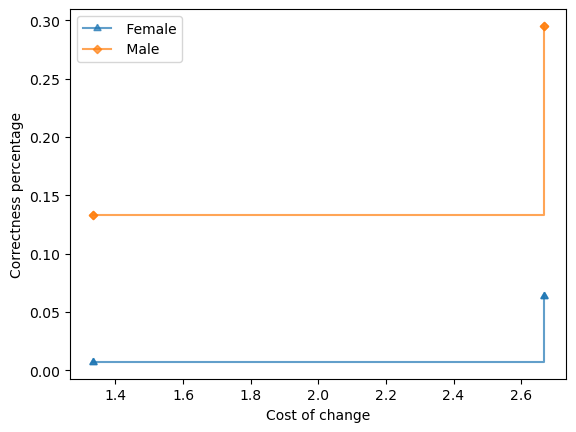

If capital-gain = 0, capital-loss = 0, education-num = 11, native-country =  United-States:
	Protected Subgroup ' Female', 3.91% covered out of 4064
		Make education-num = 13 with correctness 5.03%.
		Make education-num = 13 with correctness 5.03%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.45% covered out of 6700
		Make education-num = 13 with correctness 28.57%.
		Make education-num = 13 with correctness 28.57%.
		Aggregate cost of the above recourses = -0.11
	Bias against  Female. Unfairness measure = 0.09.
	Cumulative correctness plot for the above recourses:


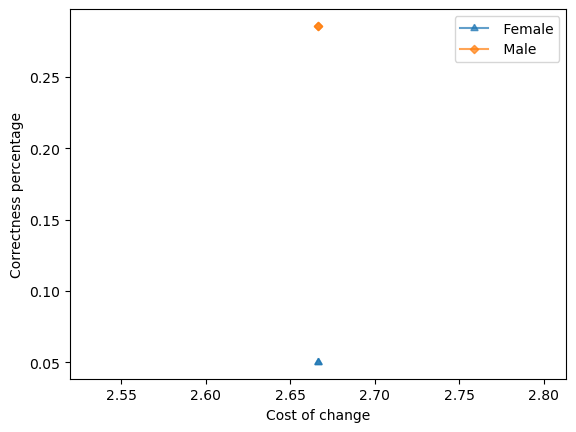

If Workclass =  Private, capital-gain = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 4.11% covered out of 4064
		Make occupation =  Exec-managerial with correctness 0.60%.
		Make occupation =  Prof-specialty with correctness 0.60%.
		Make occupation =  Sales with correctness 0.60%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 1.20%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 0.60%.
		Make occupation =  Exec-managerial with correctness 0.60%.
		Make occupation =  Prof-specialty with correctness 0.60%.
		Make occupation =  Sales with correctness 0.60%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 1.20%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 0.60%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 7.57% covered out of 6700
		Make occupation =  Exec-managerial with c

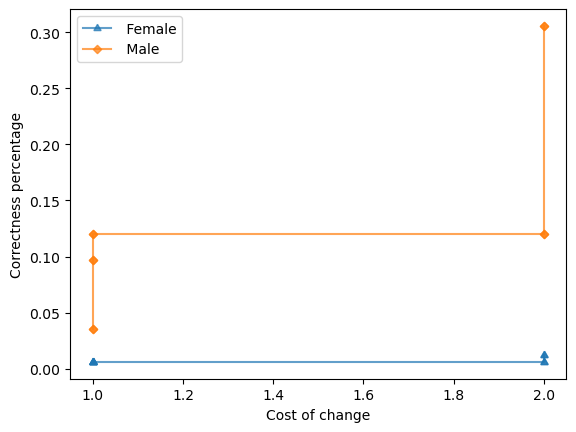

If Workclass =  Private, capital-gain = 0, capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 5.09% covered out of 4064
		Make occupation =  Exec-managerial with correctness 0.48%.
		Make occupation =  Prof-specialty with correctness 0.48%.
		Make occupation =  Sales with correctness 0.48%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 1.45%.
		Make occupation =  Exec-managerial with correctness 0.48%.
		Make occupation =  Prof-specialty with correctness 0.48%.
		Make occupation =  Sales with correctness 0.48%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 1.45%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 8.37% covered out of 6700
		Make occupation =  Exec-managerial with correctness 10.16%.
		Make occupation =  Prof-specialty with correctness 8.38%.
		Make occupation =  Sales with correctness 3.03%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-

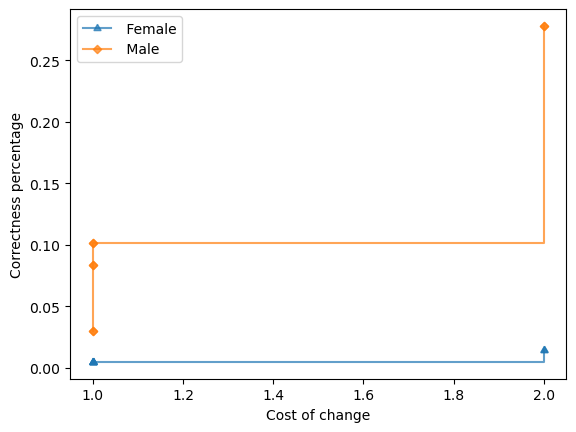

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, occupation =  Other-service:
	Protected Subgroup ' Female', 5.71% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 2.59%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Exec-managerial with correctness 0.43%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 1.29%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 0.00%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 3.88%.
		Make occupation =  Sales with correctness 0.00%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 2.16%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 2.59%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Exec-managerial with correctness 0.43%.
		Make hours-per-wee

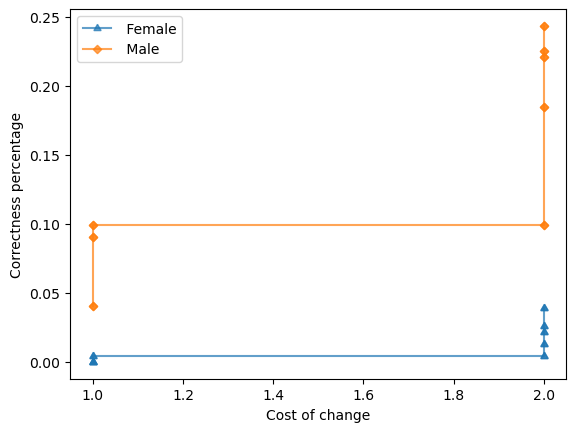

If Workclass =  Private, capital-gain = 0, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Female', 3.59% covered out of 4064
		Make occupation =  Exec-managerial with correctness 1.37%.
		Make occupation =  Prof-specialty with correctness 1.37%.
		Make occupation =  Sales with correctness 1.37%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 2.74%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 1.37%.
		Make occupation =  Exec-managerial with correctness 1.37%.
		Make occupation =  Prof-specialty with correctness 1.37%.
		Make occupation =  Sales with correctness 1.37%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 2.74%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 1.37%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 7.30% covered out of 6700
		Make occupation =  Exec-managerial with correctness 12.27%.

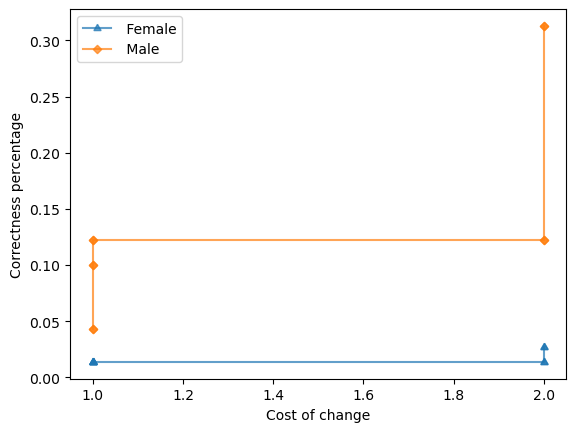

If capital-loss = 0, hours-per-week = FullTime, occupation =  Other-service, race =  White:
	Protected Subgroup ' Female', 4.23% covered out of 4064
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 2.91%.
		Make occupation =  Prof-specialty with correctness 0.58%.
		Make occupation =  Exec-managerial with correctness 1.16%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 2.33%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 0.58%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 4.07%.
		Make occupation =  Sales with correctness 0.58%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 2.91%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 2.91%.
		Make occupation =  Prof-specialty with correctness 0.58%.
		Make occupation =  Exec-managerial with correctness 1.16%.
		Make hours-per-week = OverTime, occu

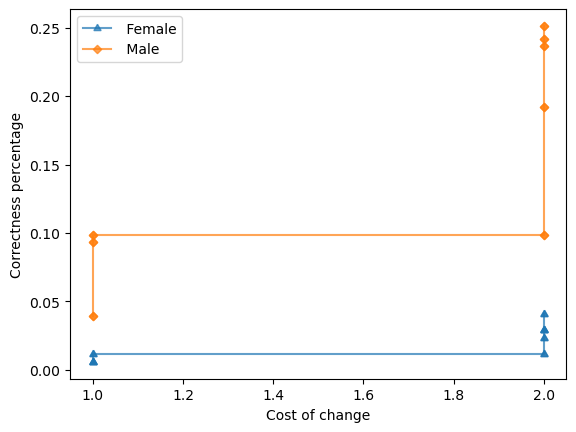

If age = (34.0, 41.0], marital-status =  Never-married, race =  White:
	Protected Subgroup ' Female', 3.20% covered out of 4064
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with correctness 30.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse with correctness 25.38%.
		Make marital-status =  Married-civ-spouse with correctness 23.08%.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with correctness 30.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse with correctness 25.38%.
		Make marital-status =  Married-civ-spouse with correctness 23.08%.
		Aggregate cost of the above recourses = -0.17
	Protected Subgroup ' Male', 3.25% covered out of 6700
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with correctness 16.06%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse with correctness 13.76%.
		Make marital-status =  Married-civ-spouse with correctness 11.47%.
		Make age = (41.0, 50.0], m

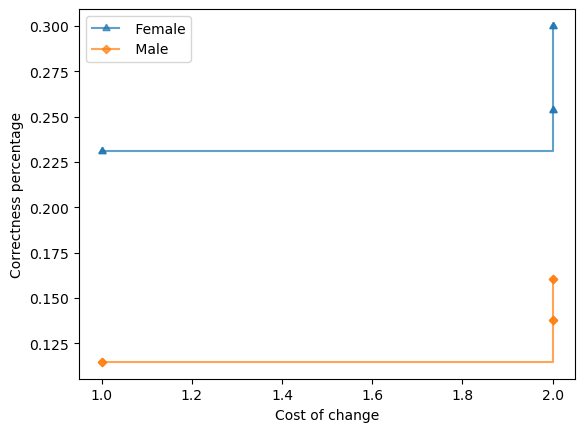

If Workclass =  Private, education-num = 10, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 6.82% covered out of 4064
		Make hours-per-week = OverTime with correctness 2.53%.
		Make hours-per-week = OverTime with correctness 2.53%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 6.78% covered out of 6700
		Make hours-per-week = OverTime with correctness 10.57%.
		Make hours-per-week = OverTime with correctness 10.57%.
		Aggregate cost of the above recourses = -0.11
	Bias against  Female. Unfairness measure = 0.08.
	Cumulative correctness plot for the above recourses:


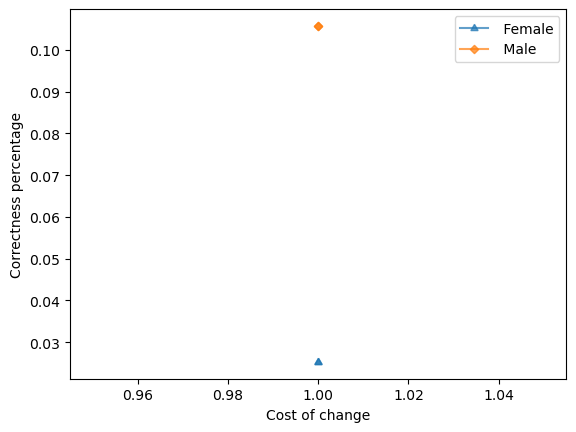

If Workclass =  Private, capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 4.16% covered out of 4064
		Make occupation =  Exec-managerial with correctness 1.18%.
		Make occupation =  Prof-specialty with correctness 1.18%.
		Make occupation =  Sales with correctness 1.18%.
		Make occupation =  Craft-repair with correctness 0.59%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 1.78%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 1.18%.
		Make occupation =  Exec-managerial with correctness 1.18%.
		Make occupation =  Prof-specialty with correctness 1.18%.
		Make occupation =  Sales with correctness 1.18%.
		Make occupation =  Craft-repair with correctness 0.59%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 1.78%.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with correctness 1.18%.
		Aggregate cost of the above 

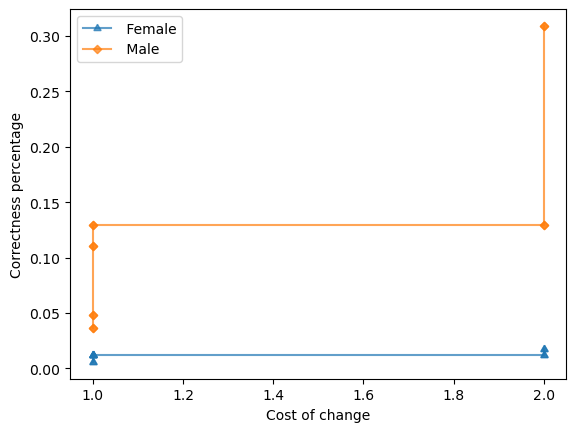

If age = (41.0, 50.0], capital-gain = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 5.81% covered out of 4064
		Make hours-per-week = OverTime with correctness 3.81%.
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make age = (50.0, 90.0], hours-per-week = OverTime with correctness 2.54%.
		Make hours-per-week = BrainDrain with correctness 4.66%.
		Make hours-per-week = OverTime with correctness 3.81%.
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make age = (50.0, 90.0], hours-per-week = OverTime with correctness 2.54%.
		Make hours-per-week = BrainDrain with correctness 4.66%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 6.22% covered out of 6700
		Make hours-per-week = OverTime with correctness 13.43%.
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make age = (50.0, 90.0], hours-per-week = OverTime with correctness 11.27%.
		Make hours-per-week = BrainDrain with correctness 

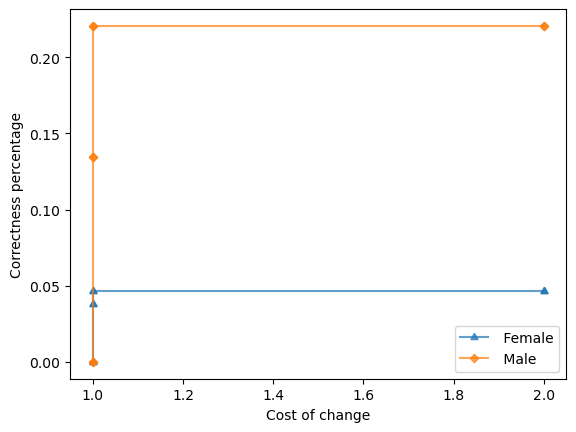

If age = (26.0, 34.0], education-num = 13:
	Protected Subgroup ' Female', 3.94% covered out of 4064
		Make age = (41.0, 50.0] with correctness 9.38%.
		Make age = (34.0, 41.0] with correctness 4.37%.
		Make age = (41.0, 50.0], education-num = 14 with correctness 12.50%.
		Make age = (34.0, 41.0], education-num = 14 with correctness 9.38%.
		Make age = (41.0, 50.0] with correctness 9.38%.
		Make age = (34.0, 41.0] with correctness 4.37%.
		Make age = (41.0, 50.0], education-num = 14 with correctness 12.50%.
		Make age = (34.0, 41.0], education-num = 14 with correctness 9.38%.
		Aggregate cost of the above recourses = -0.06
	Protected Subgroup ' Male', 3.03% covered out of 6700
		Make age = (41.0, 50.0] with correctness 19.21%.
		Make age = (34.0, 41.0] with correctness 15.27%.
		Make age = (41.0, 50.0], education-num = 14 with correctness 23.65%.
		Make age = (34.0, 41.0], education-num = 14 with correctness 19.21%.
		Make age = (41.0, 50.0] with correctness 19.21%.
		Make age = (34.0, 

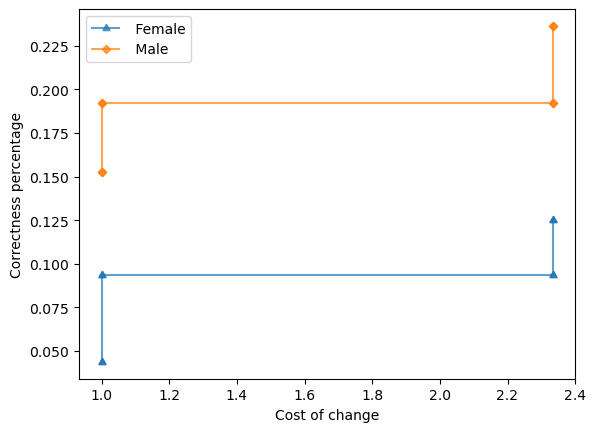

If Workclass =  Private, age = (41.0, 50.0], capital-loss = 0, education-num = 9, native-country =  United-States:
	Protected Subgroup ' Female', 4.68% covered out of 4064
		Make education-num = 10 with correctness 1.05%.
		Make education-num = 10 with correctness 1.05%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 4.39% covered out of 6700
		Make education-num = 10 with correctness 10.20%.
		Make education-num = 10 with correctness 10.20%.
		Aggregate cost of the above recourses = -0.08
	Bias against  Female. Unfairness measure = 0.07.
	Cumulative correctness plot for the above recourses:


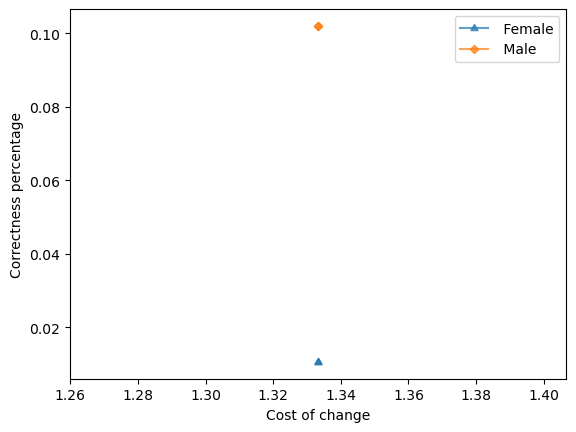

If Workclass =  Self-emp-not-inc, native-country =  United-States:
	Protected Subgroup ' Female', 3.76% covered out of 4064
		Make Workclass =  Private with correctness 2.61%.
		Make Workclass =  Self-emp-inc with correctness 7.84%.
		Make Workclass =  Local-gov with correctness 2.61%.
		Make Workclass =  Federal-gov with correctness 11.76%.
		Make Workclass =  State-gov with correctness 1.96%.
		Make Workclass =  Private with correctness 2.61%.
		Make Workclass =  Self-emp-inc with correctness 7.84%.
		Make Workclass =  Local-gov with correctness 2.61%.
		Make Workclass =  Federal-gov with correctness 11.76%.
		Make Workclass =  State-gov with correctness 1.96%.
		Aggregate cost of the above recourses = -0.05
	Protected Subgroup ' Male', 10.49% covered out of 6700
		Make Workclass =  Private with correctness 6.83%.
		Make Workclass =  Self-emp-inc with correctness 17.07%.
		Make Workclass =  Local-gov with correctness 7.25%.
		Make Workclass =  Federal-gov with correctness 22.62%.
		M

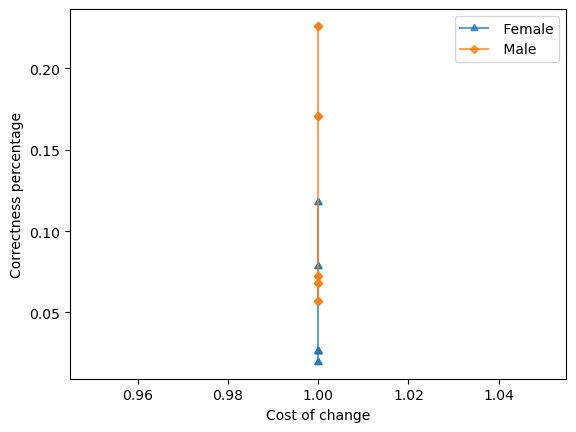

If Workclass =  Local-gov, capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Female', 3.12% covered out of 4064
		Make Workclass =  Private, hours-per-week = OverTime with correctness 0.00%.
		Make Workclass =  Private with correctness 0.00%.
		Make Workclass =  Private, hours-per-week = BrainDrain with correctness 0.00%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime with correctness 2.36%.
		Make Workclass =  Federal-gov with correctness 1.57%.
		Make Workclass =  Private, hours-per-week = OverTime with correctness 0.00%.
		Make Workclass =  Private with correctness 0.00%.
		Make Workclass =  Private, hours-per-week = BrainDrain with correctness 0.00%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime with correctness 2.36%.
		Make Workclass =  Federal-gov with correctness 1.57%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 3.27% covered out of 6700
		Make Workclass =  Private, hours-per-week = OverTime with corr

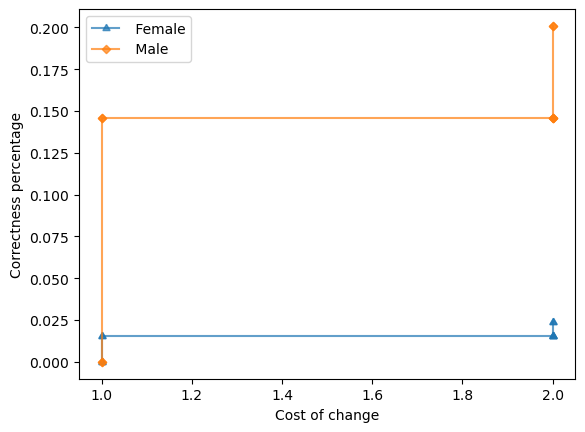

If capital-gain = 0, education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 19.12% covered out of 4064
		Make education-num = 12 with correctness 2.83%.
		Make education-num = 12 with correctness 2.83%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 18.30% covered out of 6700
		Make education-num = 12 with correctness 19.17%.
		Make education-num = 12 with correctness 19.17%.
		Aggregate cost of the above recourses = -0.07
	Bias against  Female. Unfairness measure = 0.06.
	Cumulative correctness plot for the above recourses:


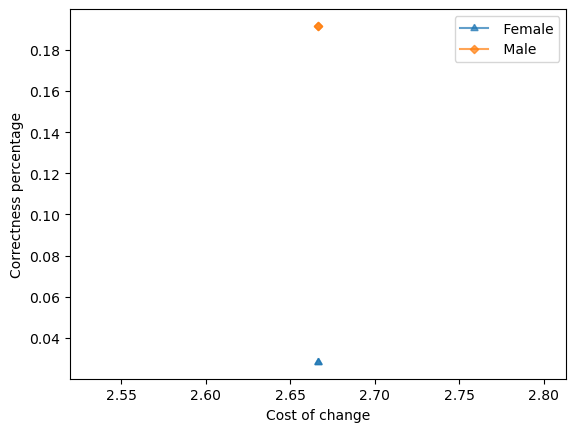

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Other-service, race =  White:
	Protected Subgroup ' Female', 10.90% covered out of 4064
		Make occupation =  Exec-managerial with correctness 0.00%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make occupation =  Exec-managerial with correctness 0.00%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 5.15% covered out of 6700
		Make occupation =  Exec-managerial with correctness 7.83%.
		Make occupation =  Prof-specialty with correctness 7.25%.
		Make occupation =  Sales with correctness 3.19%.
		Make occupation =  Exec-managerial with correctness 7.83%.
		Make occupation =  Prof-specialty with correctness 7.25%.
		Make occupation =  Sales with correctness 3.19%.
		Aggregate co

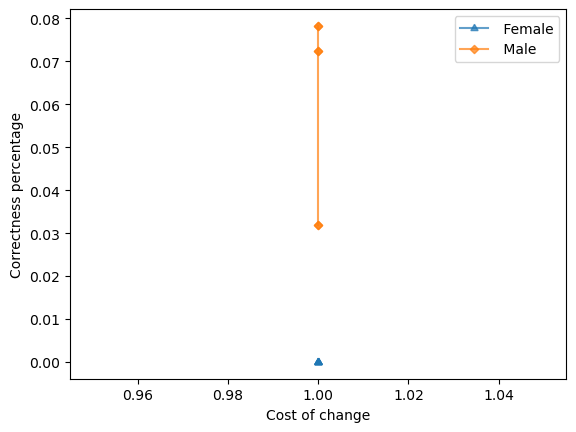

If Workclass =  Private, age = (41.0, 50.0], capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 8.54% covered out of 4064
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 1.44%.
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 1.44%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 8.16% covered out of 6700
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 13.53%.
		Make age = (50.0, 90.0] with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 13.53%.
		Aggregate cost of the above recourses = -0.07
	Bias against  Female. Unfairness measure = 0.06.
	Cumulative correctness plot for the above recourses:


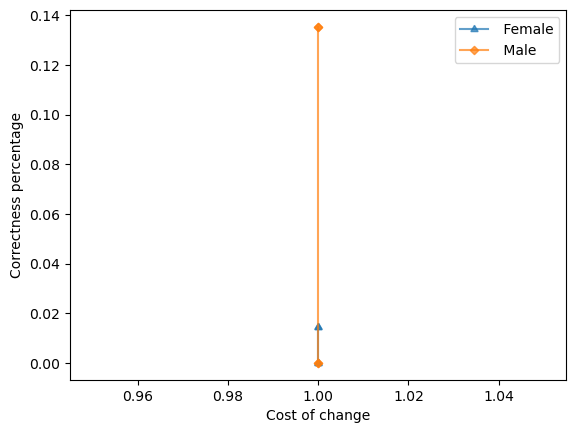

If age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, education-num = 9, native-country =  United-States:
	Protected Subgroup ' Female', 5.66% covered out of 4064
		Make education-num = 10 with correctness 2.17%.
		Make education-num = 10 with correctness 2.17%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 5.69% covered out of 6700
		Make education-num = 10 with correctness 9.97%.
		Make education-num = 10 with correctness 9.97%.
		Aggregate cost of the above recourses = -0.07
	Bias against  Female. Unfairness measure = 0.06.
	Cumulative correctness plot for the above recourses:


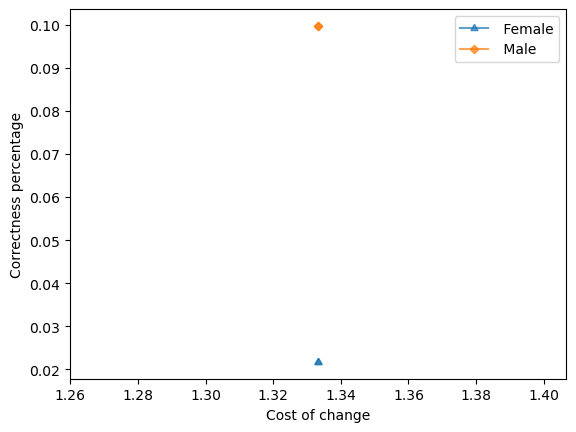

If capital-gain = 0, hours-per-week = PartTime:
	Protected Subgroup ' Female', 18.41% covered out of 4064
		Make hours-per-week = FullTime with correctness 3.07%.
		Make hours-per-week = OverTime with correctness 4.41%.
		Make hours-per-week = BrainDrain with correctness 4.81%.
		Make hours-per-week = FullTime with correctness 3.07%.
		Make hours-per-week = OverTime with correctness 4.41%.
		Make hours-per-week = BrainDrain with correctness 4.81%.
		Aggregate cost of the above recourses = -0.04
	Protected Subgroup ' Male', 9.21% covered out of 6700
		Make hours-per-week = FullTime with correctness 7.62%.
		Make hours-per-week = OverTime with correctness 10.86%.
		Make hours-per-week = BrainDrain with correctness 11.18%.
		Make hours-per-week = FullTime with correctness 7.62%.
		Make hours-per-week = OverTime with correctness 10.86%.
		Make hours-per-week = BrainDrain with correctness 11.18%.
		Aggregate cost of the above recourses = -0.10
	Bias against  Female. Unfairness measure = 0.0

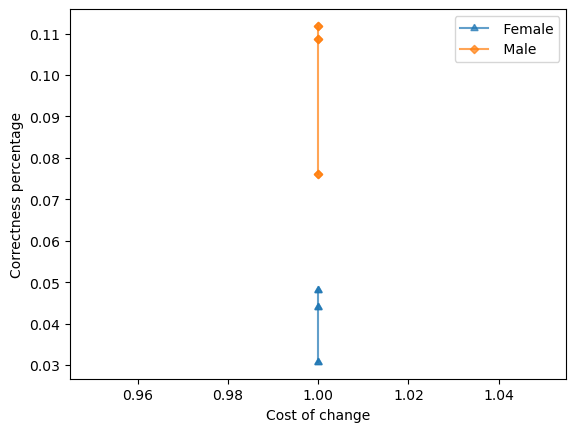

If age = (50.0, 90.0], education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 5.81% covered out of 4064
		Make education-num = 10 with correctness 0.42%.
		Make education-num = 10 with correctness 0.42%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 6.91% covered out of 6700
		Make education-num = 10 with correctness 7.99%.
		Make education-num = 10 with correctness 7.99%.
		Aggregate cost of the above recourses = -0.06
	Bias against  Female. Unfairness measure = 0.06.
	Cumulative correctness plot for the above recourses:


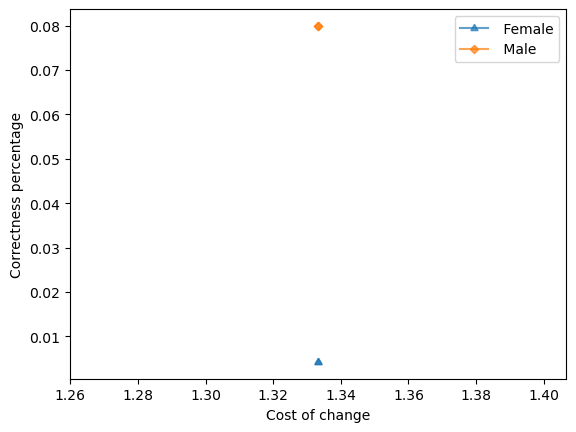

If capital-gain = 0, hours-per-week = OverTime, marital-status =  Never-married, race =  White:
	Protected Subgroup ' Female', 4.13% covered out of 4064
		Make marital-status =  Married-civ-spouse with correctness 21.43%.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse with correctness 10.12%.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with correctness 22.02%.
		Make marital-status =  Married-civ-spouse with correctness 21.43%.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse with correctness 10.12%.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with correctness 22.02%.
		Aggregate cost of the above recourses = -0.12
	Protected Subgroup ' Male', 5.52% covered out of 6700
		Make marital-status =  Married-civ-spouse with correctness 11.62%.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse with correctness 5.41%.
		Make hours-per-week = BrainDrain, marital-status =  

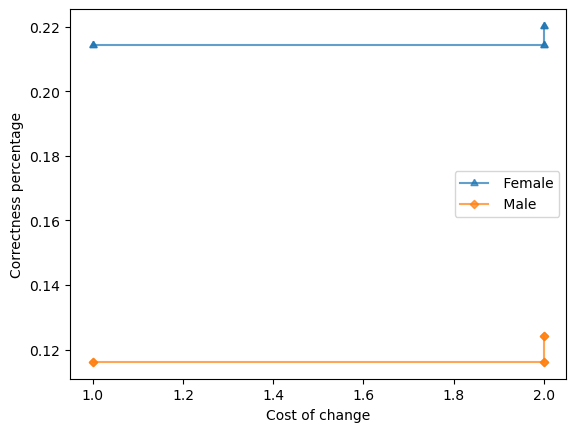

If education-num = 9, native-country =  United-States, occupation =  Other-service:
	Protected Subgroup ' Female', 7.23% covered out of 4064
		Make education-num = 10, occupation =  Exec-managerial with correctness 1.36%.
		Make occupation =  Exec-managerial with correctness 0.34%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 1.36%.
		Make occupation =  Exec-managerial with correctness 0.34%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 3.27% covered out of 6700
		Make education-num = 10, occupation =  Exec-managerial with correctness 13.70%.
		Make occupation =  Exec-managerial with correctness 5.94%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 13.70%.
		Make occupation =  Exec-managerial with correctness 5.94%.
		Aggregate cost of the above recourses = -0.06
	Bias against  Female. Unfairness measure = 0.05.
	Cumulative correctness plot for the above recourses:


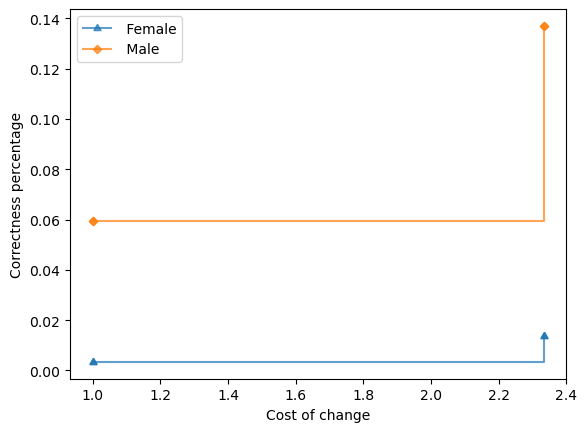

If capital-loss = 0, education-num = 9, occupation =  Other-service:
	Protected Subgroup ' Female', 7.70% covered out of 4064
		Make education-num = 10, occupation =  Exec-managerial with correctness 1.60%.
		Make occupation =  Exec-managerial with correctness 0.32%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 1.60%.
		Make occupation =  Exec-managerial with correctness 0.32%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 3.88% covered out of 6700
		Make education-num = 10, occupation =  Exec-managerial with correctness 13.08%.
		Make occupation =  Exec-managerial with correctness 6.15%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 13.08%.
		Make occupation =  Exec-managerial with correctness 6.15%.
		Aggregate cost of the above recourses = -0.06
	Bias against  Female. Unfairness measure = 0.05.
	Cumulative correctness plot for the above recourses:


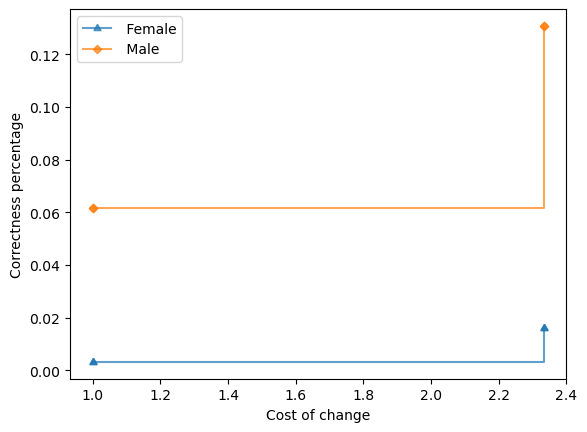

If Workclass =  Private, capital-gain = 0, native-country =  United-States, occupation =  Exec-managerial, race =  White:
	Protected Subgroup ' Female', 6.42% covered out of 4064
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 3.07%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 3.07%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 3.72% covered out of 6700
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 18.47%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 18.47%.
		Aggregate cost of the above recourses = -0

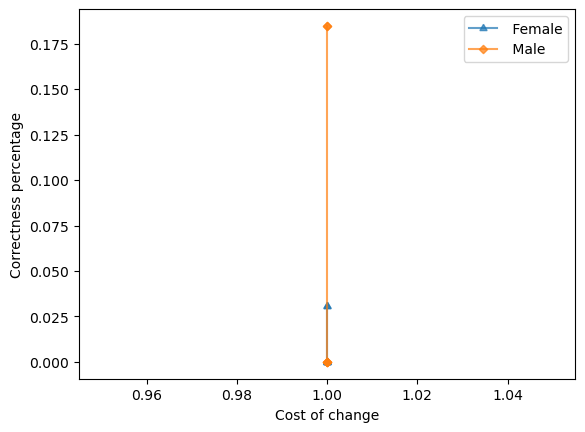

If Workclass =  Private, capital-gain = 0, capital-loss = 0, occupation =  Exec-managerial:
	Protected Subgroup ' Female', 7.73% covered out of 4064
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 2.87%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 2.87%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 4.19% covered out of 6700
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 18.15%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make Workclass =  Self-emp-inc with correctness 18.15%.
		Aggregate cost of the above recourses = -0.06
	Bias against  Female. Unf

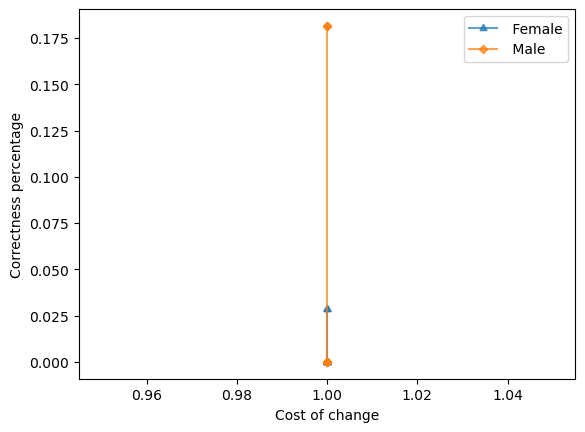

If age = (26.0, 34.0], hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 8.22% covered out of 4064
		Make age = (41.0, 50.0] with correctness 3.89%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with correctness 6.89%.
		Make age = (34.0, 41.0], hours-per-week = OverTime with correctness 4.49%.
		Make age = (34.0, 41.0] with correctness 2.40%.
		Make hours-per-week = OverTime with correctness 2.10%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain with correctness 8.68%.
		Make age = (34.0, 41.0], hours-per-week = BrainDrain with correctness 5.69%.
		Make age = (41.0, 50.0] with correctness 3.89%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with correctness 6.89%.
		Make age = (34.0, 41.0], hours-per-week = OverTime with correctness 4.49%.
		Make age = (34.0, 41.0] with correctness 2.40%.
		Make hours-per-week = OverTime with correctness 2.10%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain with corre

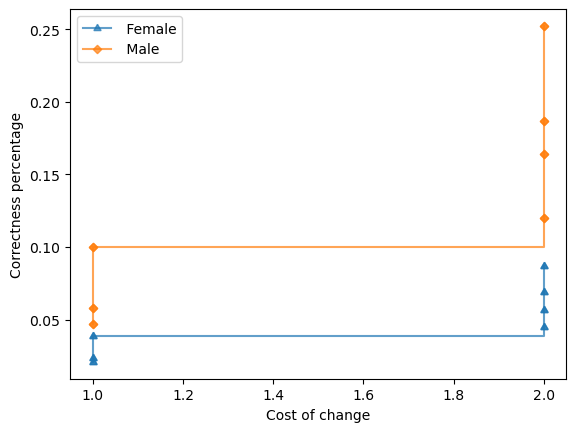

If age = (34.0, 41.0], capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 5.04% covered out of 4064
		Make age = (41.0, 50.0] with correctness 1.95%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with correctness 7.80%.
		Make age = (50.0, 90.0] with correctness 1.95%.
		Make hours-per-week = OverTime with correctness 3.90%.
		Make age = (50.0, 90.0], hours-per-week = OverTime with correctness 6.34%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain with correctness 8.78%.
		Make hours-per-week = BrainDrain with correctness 5.37%.
		Make age = (41.0, 50.0] with correctness 1.95%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with correctness 7.80%.
		Make age = (50.0, 90.0] with correctness 1.95%.
		Make hours-per-week = OverTime with correctness 3.90%.
		Make age = (50.0, 90.0], hours-per-week = OverTime with correctness 6.34%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain with correct

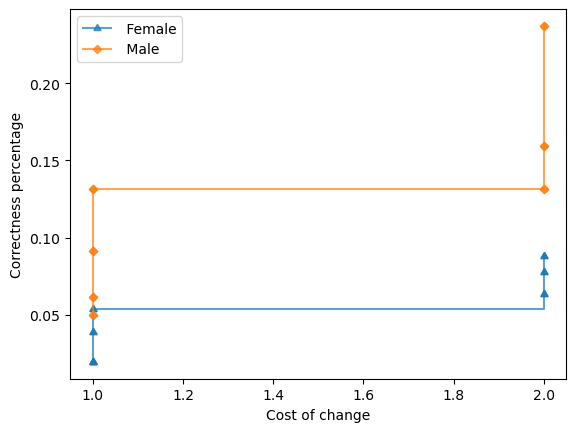

If Workclass =  Private, age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 8.07% covered out of 4064
		Make age = (41.0, 50.0] with correctness 2.44%.
		Make age = (50.0, 90.0] with correctness 2.13%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0] with correctness 8.54%.
		Make age = (41.0, 50.0] with correctness 2.44%.
		Make age = (50.0, 90.0] with correctness 2.13%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0] with correctness 8.54%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 10.25% covered out of 6700
		Make age = (41.0, 50.0] with correctness 7.57%.
		Make age = (50.0, 90.0] with correctness 5.97%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0] with correctness 19.07%.
		Make age = (41.0, 50.0] with correctness 7.57%.
		Make age = (50.0, 90.0] with correctness 5.97%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0] with correctness 19.07%.
		Aggregate cost o

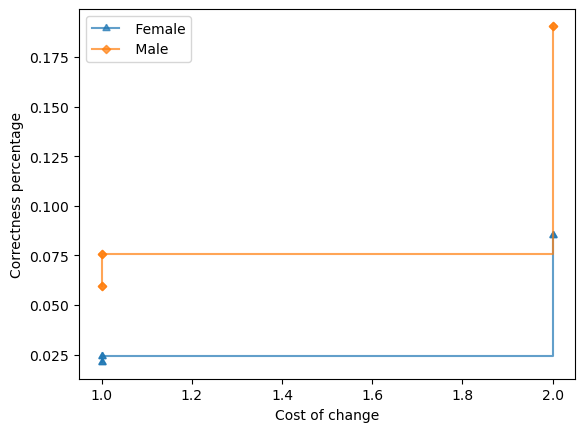

In [34]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 500,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
    ],
    cor_threshold=None,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

## Minimum cost above threshold

In [28]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, age = (26.0, 34.0], marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 5.19% covered out of 4064
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 54.50%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 63.51%.
		Make Workclass =  Local-gov, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 56.40%.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 54.50%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 63.51%.
		Make Workclass =  Local-gov, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 56.40%.
		Aggregate cost of the above recourses = 12.00


## Mean cost above threshold

In [32]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 20.50% covered out of 4064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 4.73% covered out of 6700
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 28.71%.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 28.71%.
		Aggregate cost of the above recourses = 2.00
	Bias against  Female. Unfairness measure = inf.
If hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 14.81% covered out of 4064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 3.57% covered out of 6700
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.47%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 30.13%.
		Make hours-per-week = BrainDrain, occupation =  Ex

## Number above threshold

In [33]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 14.81% covered out of 4064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 3.57% covered out of 6700
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.47%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 30.13%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 34.73%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 33.47%.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.47%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 30.13%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 34.73%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 33.47%.
		Aggregate cost of the above re